In [109]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import Image
from PIL import Image as Img
from PIL import ImageTk
%matplotlib inline 

In [110]:
def normalize(value): # Нормализация для значения
  if value < 0:
    return 0
  elif value > 255:
    return 255
  else:
    return value


def normalize_img(img): # Нормализация всего изображения
  img = img[:-1, :]
  img[img < 0] = 0
  img[img > 255] = 255
  return img.astype(np.uint8)


def htransit(L1, L2, L3, V1, V3): # hue_transit реализация
  if L1 < L2 < L3 or L1 > L2 > L3:
    return V1 + (V3 - V1) * (L2 - L1) / (L3 - L1)
  return (V1 + V3) / 2 + (L2 - (L1 + L3) / 2) / 2

In [120]:
def generate_green(p, i=0):
  directions = list()
  directions.append(abs(p[2, 2, i] - p[0, 2, i]) * 2 + abs(p[1, 2, 1] - p[3, 2, 1]))
  directions.append(abs(p[2, 2, i] - p[2, 4, i]) * 2 + abs(p[2, 1, 1] - p[2, 3, 1]))
  directions.append(abs(p[2, 2, i] - p[2, 0, i]) * 2 + abs(p[2, 1, 1] - p[2, 3, 1]))
  directions.append(abs(p[2, 2, i] - p[4, 2, i]) * 2 + abs(p[1, 2, 1] - p[3, 2, 1]))

  variants = [(p[1, 2, 1] * 3 + p[3, 2, 1] + p[2, 2, i] - p[0, 2, i]) / 4, \
              (p[2, 3, 1] * 3 + p[2, 1, 1] + p[2, 2, i] - p[2, 4, i]) / 4, \
              (p[2, 1, 1] * 3 + p[2, 3, 1] + p[2, 2, i] - p[2, 0, i]) / 4, \
              (p[3, 2, 1] * 3 + p[1, 2, 1] + p[2, 2, i] - p[4, 2, i]) / 4]
  return variants[np.argmin(directions)]


def generate_red_and_blue(p, swap):
  i, j = 0, 2
  if swap:
    i, j = j, i

  NE = abs(p[1, 3, j] - p[3, 1, j]) + abs(p[0, 4, i] - p[2, 2, i]) \
    + abs(p[2, 2, i] - p[4, 0, i]) + abs(p[1, 3, 1] - p[2, 2, 1]) \
    + abs(p[3, 1, 1] - p[2, 2, 1])
  NW = abs(p[1, 3, j] - p[3, 1, j]) + abs(p[0, 0, i] - p[2, 2, i]) \
    + abs(p[2, 2, i] - p[4, 4, i]) + abs(p[1, 1, 1] - p[2, 2, 1]) \
    + abs(p[3, 3, 1] - p[2, 2, 1])

  if NE < NW:
    return htransit(p[1, 3, 1], p[2, 2, 1], p[3, 1, 1], p[1, 3, j], p[3, 1, j])
  return htransit(p[1, 1, 1], p[2, 2, 1], p[3, 3, 1], p[1, 1, j], p[3, 3, j])

In [113]:
def first_stage(p, bayer, img, i, j): 
  if bayer[0, 0] == 'r':
    value = generate_green(p)
    img[i - 2, j - 2, 1] = normalize(value)
  elif bayer[0, 0] == 'b':
    value = generate_green(p, 2)
    img[i - 2, j - 2, 1] = normalize(value)

In [114]:
def second_stage(p, bayer, img, i, j):
  if bayer[0, 0] == 'g':
    if bayer[1, 0] == 'r':
      r = htransit(p[1, 2, 1], p[2, 2, 1], p[3, 2, 1], p[1, 2, 0], p[3, 2, 0])
      b = htransit(p[2, 1, 1], p[2, 2, 1], p[2, 3, 1], p[2, 1, 2], p[2, 3, 2])
      img[i - 2, j - 2, (0, 2)] = normalize(r), normalize(b)
    else:
      r = htransit(p[2, 1, 1], p[2, 2, 1], p[2, 3, 1], p[2, 1, 0], p[2, 3, 0])
      b = htransit(p[1, 2, 1], p[2, 2, 1], p[3, 2, 1], p[1, 2, 2], p[3, 2, 2])
      img[i - 2, j - 2, (0, 2)] = normalize(r), normalize(b)

In [115]:
def third_stage(p, bayer, img, i, j): 
  if bayer[0, 0] == 'r':
    value = generate_red_and_blue(p, False)
    img[i - 2, j - 2, 2] = normalize(value)
  elif bayer[0, 0] == 'b':
    value = generate_red_and_blue(p, True)
    img[i - 2, j - 2, 0] = normalize(value)

In [116]:
def apply(pimg, img, bayer, stage):
  statistic = 0
  persentage = 20
  for i in range(2, pimg.shape[0] - 2):
    for j in range(2, pimg.shape[1] - 2):
      statistic+=1
      if statistic / (pimg.shape[0] - 4) / (pimg.shape[1] - 4) > persentage/100:
        print(persentage, '%')
        persentage += 20
      stage(pimg[i - 2:i + 3, j - 2:j + 3], bayer, img, i, j)
      bayer[:, (0, 1)] = bayer[:, (1, 0)]
    bayer[(0, 1), :] = bayer[(1, 0), :]


def create_padded_img(img): # Паддинг для изображения
  pimg = np.concatenate((img[:2, :][::-1, :, :], img))
  pimg = np.concatenate((pimg, pimg[-3:, :][::-1, :, :]))
  pimg = np.concatenate((pimg[:, :2][:, ::-1, :], pimg), axis=1)
  pimg = np.concatenate((pimg, pimg[:, -2:][:, ::-1, :]), axis=1)
  pimg = pimg.astype(float)
  return pimg


def reconstruct(image, bayer):
  pimg = create_padded_img(image)
  pimg = pimg.astype(float)

  img = image.copy().astype(float)
  img = np.concatenate((img, img[-1:, :]))

  apply(pimg, img, bayer, first_stage)
  print("first_stage done")
  apply(pimg, img, bayer, second_stage)
  print("second_stage done")
  apply(pimg, img, bayer, third_stage)
  print("third_stage done")

  img = normalize_img(img)

  return img

In [117]:
def construct_picture(CFA_name, resoult_name): # Применение алгоритма
  img = plt.imread(CFA_name)

  bayer_filter = np.array([['r', 'g'], ['g', 'b']])
  start_time = time.time()
  res = reconstruct(img, bayer_filter)

  img = Img.fromarray(res.astype(np.uint8))
  img.save(resoult_name)

  return time.time() - start_time

In [118]:
def analytics(original_name, resoult_name, time=0): # Аналитика алгоритма
  original = plt.imread(original_name)
  res = plt.imread(resoult_name)

  megapixel_count = original.shape[0] * original.shape[1] / 100000

  PSNR = 10 * np.log10(255 ** 2 / (np.sum((np.array(original) - np.array(res)) ** 2) / (original.shape[0] * original.shape[1])))
  
  print("Время работы", time, "sec") 
  print(time / megapixel_count, "sec/mgpixel")
  
  print("PSNR = ", PSNR)
  
  plt.imshow(original)
  plt.imshow(res)

In [126]:
def div(original_name, resoult_name): # Аналитика алгоритма
  original = plt.imread(original_name)
  res = plt.imread(resoult_name)

  plt.imshow(original-res)

  img = Img.fromarray((original-res).astype(np.uint8))
  img.save('sub_img.bmp')

In [121]:
algo_time = construct_picture('RGB_CFA.bmp', 'res.bmp')

(2078, 4180, 3) shape
20 %
40 %
60 %
80 %
first_stage done
20 %
40 %
60 %
80 %
second_stage done
20 %
40 %
60 %
80 %
third_stage done


Время работы 440.1287019252777 sec
5.084168070471813 sec/mgpixel
PSNR =  28.97856771111968


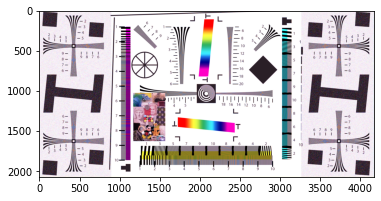

In [122]:
analytics('Original.bmp', 'res.bmp', algo_time)

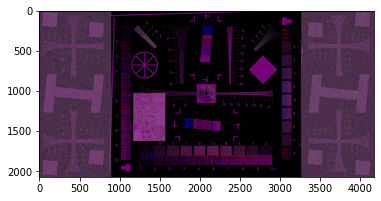

In [127]:
div('Original.bmp', 'res.bmp')